In [21]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
from sklearn.linear_model import LinearRegression
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [22]:
sdata = pd.read_csv("data/StudentsPerformance.csv")


In [23]:
sdata["average score"] = (sdata["math score"] + sdata["reading score"] + sdata["writing score"])/3


In [24]:
sdata["average score"]

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: average score, Length: 1000, dtype: float64

In [25]:

sdata.loc[[0]]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667


In [26]:
from sklearn.preprocessing import OneHotEncoder

en = OneHotEncoder(handle_unknown="ignore")
en_temp = pd.DataFrame(en.fit_transform(sdata[["gender"]]).toarray())
en_temp.columns = en.get_feature_names_out(["gender"])
sdata.drop(["gender"],axis=1,inplace=True)
sdata = sdata.join(en_temp)


en_temp = pd.DataFrame(en.fit_transform(sdata[["race/ethnicity"]]).toarray())
en_temp.columns = en.get_feature_names_out(["race/ethnicity"])
sdata.drop(["race/ethnicity"],axis=1,inplace=True)
sdata = sdata.join(en_temp)



en_temp = pd.DataFrame(en.fit_transform(sdata[["test preparation course"]]).toarray())
en_temp.columns = en.get_feature_names_out(["test preparation course"])
sdata.drop(["test preparation course"],axis=1,inplace=True)
sdata = sdata.join(en_temp)

en_temp = pd.DataFrame(en.fit_transform(sdata[["lunch"]]).toarray())
en_temp.columns = en.get_feature_names_out(["lunch"])
sdata.drop(["lunch"],axis=1,inplace=True)
sdata = sdata.join(en_temp)







AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names_out'

In [27]:
sdata["parental level of education"] = sdata["parental level of education"].replace('some high school',1)
sdata["parental level of education"] = sdata["parental level of education"].replace('high school',2)
sdata["parental level of education"] = sdata["parental level of education"].replace('some college',3)
sdata["parental level of education"] = sdata["parental level of education"].replace("associate's degree", 4)
sdata["parental level of education"] = sdata["parental level of education"].replace("bachelor's degree" ,5)
sdata["parental level of education"] = sdata["parental level of education"].replace("master's degree",6)








In [28]:
sdata.loc[[0]]
sdata.dtypes


gender                          object
race/ethnicity                  object
parental level of education      int64
lunch                           object
test preparation course         object
math score                       int64
reading score                    int64
writing score                    int64
average score                  float64
dtype: object

In [29]:
sdata["binnedaverage"] = pd.qcut(sdata["average score"],4,retbins=False,labels=[1,2,3,4])
# sdata["test preparation course"] = pd.qcut(sdata["test preparation course"],2,retbins=False,labels=[0,1])

#sdata["test preparation course_completed"].astype("category")
#sdata["test preparation course_none"].astype("category")
sdata["binned education"] = pd.cut(sdata["parental level of education"],4,retbins=False,labels=[1,2,3,4])









In [30]:
sdata.loc[[0]]


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score,binnedaverage,binned education
0,female,group B,5,standard,none,72,72,74,72.666667,3,4


In [31]:
from sklearn.datasets import fetch_openml 

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

X_train,X_test, y_train, y_test = train_test_split(sdata[["parental level of education"]], sdata["binnedaverage"], random_state=0)




pipe = Pipeline([('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
# The pipeline can be used as any other estimator
 # and avoids leaking the test set into the train set
pipe.fit(X_train, y_train)
Pipeline(steps=[('scaler', StandardScaler()), ('model', KNeighborsClassifier())])
print(pipe.score(X_test, y_test))








model = KNeighborsClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

cvs = cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")
print(cvs)



y_train_pred = cross_val_predict(model, X_train, y_train, cv=3)



confuse = confusion_matrix(y_train,y_train_pred)

confusePlot = ConfusionMatrixDisplay(confuse)


print(confuse)

print(classification_report(y_train,y_train_pred))





[0.22  0.232 0.228]
[[36 64 55 35]
 [27 65 52 36]
 [51 60 42 34]
 [43 61 62 27]]
              precision    recall  f1-score   support

           1       0.23      0.19      0.21       190
           2       0.26      0.36      0.30       180
           3       0.20      0.22      0.21       187
           4       0.20      0.14      0.17       193

    accuracy                           0.23       750
   macro avg       0.22      0.23      0.22       750
weighted avg       0.22      0.23      0.22       750



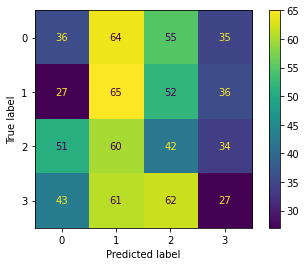

In [33]:

confusePlot.plot()

In [34]:
FP = confuse.sum(axis=0) - np.diag(confuse)  
FN = confuse.sum(axis=1) - np.diag(confuse)
TP = np.diag(confuse)
TN = confuse.sum() - (FP + FN + TP)

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print(TPR,FPR)




[0.18947368 0.36111111 0.22459893 0.13989637] [0.21607143 0.3245614  0.30017762 0.18850987]


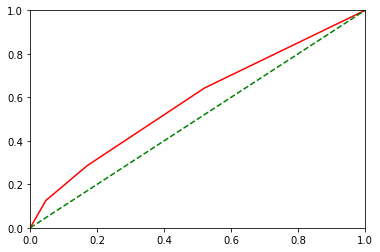

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


fpr,tpr,threshold = roc_curve(y_test,y_pred,pos_label=4)
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr,'r')
plt.xlim([0,1])
plt.ylim([0,1])
plt.plot([0,1],[0,1],'g--')
plt.show()

